In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('./train.csv')

In [5]:
print(df.shape)
print(df.columns.to_list())
print(df.iloc[0])

(16784, 30)
['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price', 'price']
listing_id                                                     1030324
title                           BMW 3 Series 320i Gran Turismo M-Sport
make                                                               bmw
model                                                             320i
description          1 owner! 320i gt m-sports model! big brake kit...
manufactured                                                    2013.0
original_reg_date                                                  NaN
reg_date                                                   09-dec-2013
type_of_vehicle             

In [6]:
d1 = df['original_reg_date'].isnull()
df['age'] = df['original_reg_date'].copy()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['manufactured'][d1]

def extract_year(date):
    date = str(date)
    if len(date) != 4:
        if '.' in date and len(date) == 6:
            year = date[:-2]
        else:
            l = date.split('-')
            year = l[-1]
    return int(year)
df['age'] = 2021 - df['age'].map(extract_year)

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
# take out outliers
df['age'] = df['age'][df.age < 30]
df['age'] = df['age'][df.age >= 0]
print(df['age'])
print(df['age'].isna().sum())
df = df.dropna(subset=['age'])

0         8.0
1         6.0
2         5.0
3         1.0
4         2.0
         ... 
16779     5.0
16780     4.0
16781    11.0
16782     1.0
16783     3.0
Name: age, Length: 16784, dtype: float64
108


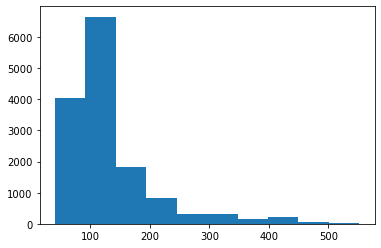

In [8]:
# power
plt.figure()
plt.hist(df["power"].to_numpy())
plt.show()

In [9]:
print(len(df[df.power > 400]))
print(df["power"].isnull().sum())

310
2253


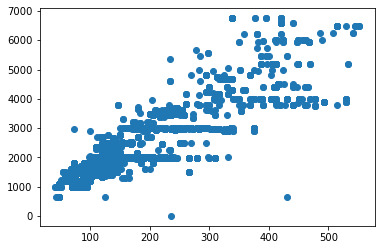

In [10]:
# plot correlation between power and engine cap
plt.scatter(df["power"], df["engine_cap"])
plt.show()

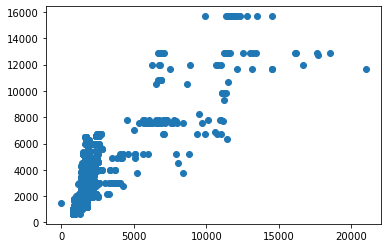

In [11]:
# plot correlation between power and engine cap
plt.scatter(df["curb_weight"], df["engine_cap"])
plt.show()

In [12]:
# engine cap
print(df["engine_cap"].isnull().sum())
# df = df.dropna(subset = ["engine_cap"]) # only dropping 53

53


In [13]:
# take out outliers acccording to scatter plot
df = df[~((df['power'] > 200) & (df['engine_cap'] < 1000))]

df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 100

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']

    diff = np.abs(caps - e)

    indices = np.argsort(diff)[:k]

    k_powers = powers[indices]

    avg = np.average(k_powers)
    
    # Set the weight value of the current row to the median
    df.at[idx, 'power'] = avg

0
10000


In [14]:
# take out outliers acccording to scatter plot
df_valid = df.dropna(subset = ['curb_weight', 'engine_cap'])
powers = df_valid['curb_weight'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 100

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['curb_weight'], row['engine_cap']

    diff = np.abs(caps - e)

    indices = np.argsort(diff)[:k]

    k_powers = powers[indices]

    avg = np.average(k_powers)
    
    # Set the weight value of the current row to the median
    df.at[idx, 'engine_cap'] = avg

0
10000


In [15]:
print(df["engine_cap"].isnull().sum())

0


In [16]:
print(df['mileage'].isnull().sum())
df['mileage'] = df['mileage'].fillna(df['mileage'].mode())

3647


In [17]:
## estimated omv
from sklearn.linear_model import LinearRegression
df_ = df.copy()
df_ = df_.dropna(subset=['omv', 'age', 'price'])
omv = np.array(df_['price']).reshape(-1, 1)
# omv = omv[:100]
age = np.array(df_['age']).reshape(-1, 1)
# age = age[:100]
X = np.concatenate((omv, age), axis=1)
y = np.array(df_['omv']).reshape(-1, 1)
# y = y[:100]
# print(X.shape, y.shape)
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
# reg.predict(np.array([[3, 5]]))

0.7050812818555809
[[2.88173369e-01 2.45263961e+03]]


In [18]:
# fill omv, get data with missing omv and dereg_value, fill in the omv
is_ = df[df.omv.isnull() & df.dereg_value.isnull()].index.tolist()
filled_omvs = []
for idx in is_:
    ag = df.at[idx, 'age']
    price = df.at[idx, 'price']
    mo = reg.predict(np.array([[ag, price]]))
    filled_omvs.append(mo)
for i, idx in enumerate(is_):
    df.at[idx, 'omv'] = filled_omvs[i]

In [19]:
# coe: fill in missing value for coe according to: age and power
fill_arf = df[df.arf.isnull() & df.dereg_value.isnull()]['arf'].index.tolist()
for idx in fill_arf:
    omv = df.at[idx, 'omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull() & df.dereg_value.isnull()]))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

0


In [20]:
# recalculate reg date: total months
def to_months(x):
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return int(x)
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

df = df.dropna(subset = ['reg_date'])
df['age_in_month'] = df['reg_date'].map(to_months)

In [21]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

83


In [22]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        l = t_to_coe[t]
        if len(l) > 0:
            avg = sum(l) / len(l)
            df.at[idx, 'coe'] = avg
            c += 1
print(c)

0
10000
853


In [23]:
print(df['coe'].isnull().sum())

34


In [24]:
df = df[~(df.coe.isnull() & df.dereg_value.isnull())]

In [25]:
print(df["road_tax"].median())
# df = df.fillna()
# df["road_tax"] = df["road_tax"].map(clean_tax)

974.0


In [26]:
df["road_tax"] = df["road_tax"].fillna(974)

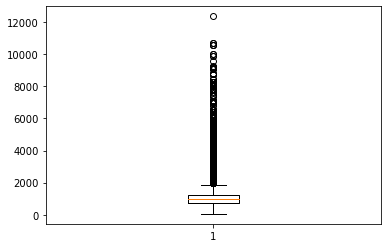

In [27]:
plt.figure()
plt.boxplot(df["road_tax"])
plt.show()

In [28]:
import math
for idx, row in df.iterrows():
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age_in_month"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        coe_rebate = coe * time_left / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = 0
        df.at[idx, "dereg_value"] = dereg_value

In [29]:
df = df.dropna(subset = ['depreciation'])

In [30]:
print(df.columns.to_list())

['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price', 'price', 'age', 'age_in_month']


In [31]:
# drop irrelevant
df = df.drop(columns = ['curb_weight', 'coe', 'omv', 'arf', 'original_reg_date','reg_date', 'age_in_month', 'opc_scheme', 'listing_id', 'indicative_price'])

In [32]:
print(df.shape)

(16235, 22)


In [33]:
df.head()

,title,make,model,description,manufactured,type_of_vehicle,category,transmission,power,fuel_type,...,depreciation,road_tax,dereg_value,mileage,lifespan,eco_category,features,accessories,price,age
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,luxury sedan,"parf car, premium ad car, low mileage car",auto,144.828,NaN,...,17700.0,1210.0,47514.0,73000.0,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",71300.0,8.0
1,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,van,premium ad car,manual,253.120,diesel,...,11630.0,974.0,3648.0,110112.0,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,43800.0,6.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,luxury sedan,"parf car, premium ad car",auto,100.680,NaN,...,15070.0,740.0,44517.0,80000.0,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,95500.0,5.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,luxury sedan,"parf car, almost new car, consignment car",auto,90.010,NaN,...,16400.0,684.0,80301.0,9800.0,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,197900.0,1.0
4,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,mid-sized sedan,parf car,auto,101.449,NaN,...,10450.0,742.0,36453.0,40000.0,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",103200.0,2.0


In [34]:
df.to_csv('numerical_cleaned.csv')  